This notebook explains use of Sequential NN architecture, Residual Connection and Inception layers architecture models. Each of such architectures have their specific design methodology and have been explained below with case study. Quite a few images referred into this notebook are being ibtained from published article and i acknowlddge their contribution for this. Have used openly available bengali charecters for identification.

Case study is about identification of bengali charecter and have used public dataset for testing. Have used Resnet, Inception layer and Sequential network architecture to implement the same. Aim here is to explain how we can deploy the network.
Following network optimistaion approaches have been used here.
- Reducing learning rate with validtaion loss monitoring
- Transfer Learning
- Layers weights manipulation for trainable and non-trainable


In [1]:
import numpy as np
import scipy
import os
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation,Add,ZeroPadding2D,GlobalMaxPooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,regularizers,Convolution2D
from keras.preprocessing .image import ImageDataGenerator
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from matplotlib import pyplot as plt   
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import load_model
from keras import regularizers
import cv2
#FinalModel.add(modelNew)
from keras import regularizers
from keras import layers
from keras.callbacks import *
from keras import applications
import sys
from sklearn.metrics import confusion_matrix
from keras.layers import Input
from keras import initializers


Using TensorFlow backend.


# Image Loading

Data is being divided into Testing and train data and we are counting the number of image here

In [2]:
ROOT_DIR = os.path.abspath("../")
print(ROOT_DIR)
TRAIN_DIR = '../bengalilang/Train/'

TEST_DIR = '../bengalilang/Test/'

print("Path Is:",TRAIN_DIR)

#sys.path.append(os.path.join(ROOT_DIR, EXTENSION_PATH))  # To find local version

train =   [TRAIN_DIR for inputD in os.listdir(TRAIN_DIR)]
test =  [TEST_DIR for inputT in os.listdir(TEST_DIR) ]


print("No of Training Bengali Images:",len(train))
print("No of Test Images:",len(test))

C:\Users\akayal\Devapps
Path Is: ../bengalilang/Train/
No of Training Bengali Images: 50
No of Test Images: 50


This function is being used to plot training, validation accuracy and loss w.r.t epocs.

In [3]:
def plot_training(mhistory):
    Fntnvggacc = mhistory.history['acc']
    Fntnvggval_acc = mhistory.history['val_acc']
    Fntnvggloss = mhistory.history['loss']
    Fntnvggval_loss = mhistory.history['val_loss']
    Fntnvggepochs = range(1, len(Fntnvggacc) + 1)
    plt.plot(mhistory, Fntnvggacc, 'bo', label='Training acc')
    plt.plot(mhistory, Fntnvggval_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.savefig('accuracy.png')
    
    plt.plot(Fntnvggepochs, Fntnvggloss, 'bo', label='Training loss')
    plt.plot(Fntnvggepochs, Fntnvggval_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss -VGG with Finetune')
    plt.legend()
    plt.show()

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig('accuracy.png')
    
    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.savefig('loss.png')

Here we will use the monitoring capability of validation loss and if this does not get reduced by 5 iteration then it will be going to early stopping.

In [4]:
#reduce_lr_rev = ReduceLROnPlateau(monitor='val_loss', factor=0.002,
 #                             patience=2, min_lr=0.005)

reduce_lr_rev = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

We will use image preprocessing here for our training data. This will help our model to be generalised.

In [5]:
# we create two instances with the same arguments
data_gen_args_rev = dict(
    rescale=1./255,
    rotation_range=35,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.35
)


We are not using any preprocessing for validation data and only doing the rescaling as NN works better when data's are scaled.

In [6]:
## validation data are not being augmented
val_data_gen_args_rev = dict(
        #rotation_range=10,
       # width_shift_range=0.1,
       # height_shift_range=0.1,
        rescale=1./255)


In [7]:
image_datagen_prep_rev = ImageDataGenerator(**data_gen_args_rev)
test_image_datagen_prep_rev = ImageDataGenerator(**val_data_gen_args_rev)

Here class_mode not provided and Default: None. If not provided, the list of classes will be automatically inferred from the subdirectory names/structure under directory, where each subdirectory will be treated as a different class (and the order of the classes, which will map to the label indices, will be alphanumeric). The dictionary containing the mapping from class names to class indices can be obtained via the attribute class_indices.

In [8]:

BATCH_SIZE =64
image_width =50
image_height=50

train_generator_data_rev = image_datagen_prep_rev.flow_from_directory(directory = TRAIN_DIR,
                                                                      target_size=(image_width,image_height),
                                                                      class_mode='categorical',
                                                                      batch_size=BATCH_SIZE,
                                                                      subset="training")

validation_generator_data_rev = image_datagen_prep_rev.flow_from_directory(directory = TRAIN_DIR,
                                                                           target_size=(image_width,image_height),
                                                                           class_mode='categorical',
                                                                           batch_size=BATCH_SIZE,
                                                                           seed=13,
                                                                           subset="validation")


Found 7800 images belonging to 50 classes.
Found 4200 images belonging to 50 classes.


In [9]:
test_generator_data_rev = test_image_datagen_prep_rev.flow_from_directory(directory = TEST_DIR,
                                                                           target_size=(image_width,image_height),
                                                                           class_mode='categorical',
                                                                           batch_size=BATCH_SIZE)

Found 3000 images belonging to 50 classes.


# Sequential Neural Network 

This is a sequential model and we have started with 32 filter initially and then gradually increased to 64 and 128. It is a standard practise to use less no of filter initially and then we increase no if filters. Softmax activation function being used for classification. Here we have 50 no of class and so no of neuron into last layer has been taken as same.

In [33]:
CNNModel_Rev = Sequential()

#convolution 1st layer
droprate=0.3
droprateRev=0.5
#convolution 1st layer
CNNModel_Rev.add(Conv2D(32,(3,3), activation='relu', strides=(1, 1), padding='same', input_shape=(image_height,image_width,3),name ="First_CV_Layer"))
#model.add(Conv2D(32,(3,1), activation='relu', strides=(1, 1), padding='valid',input_shape=input_24)#(input_24)
CNNModel_Rev.add(BatchNormalization())
CNNModel_Rev.add(MaxPooling2D())
CNNModel_Rev.add(Dropout(droprate))#3

#convolution 2nd layer
CNNModel_Rev.add(Conv2D(64,(3,3), padding='valid',activation='relu',name ="Second_CV_Layer"))
CNNModel_Rev.add(BatchNormalization())
CNNModel_Rev.add(MaxPooling2D())
CNNModel_Rev.add(Dropout(droprate))#3

#convolution 3rd layer
CNNModel_Rev.add(Conv2D(128,(3,3), padding='valid',activation='elu',name ="Third_CV_Layer"))
CNNModel_Rev.add(BatchNormalization())
CNNModel_Rev.add(MaxPooling2D())
CNNModel_Rev.add(Dropout(droprateRev))#3

#convolution 3rd layer
CNNModel_Rev.add(Conv2D(256,(3,3), padding='valid',activation='elu',name ="Fourth_CV_Layer"))
CNNModel_Rev.add(BatchNormalization())
CNNModel_Rev.add(MaxPooling2D())
CNNModel_Rev.add(Dropout(droprateRev))#3


#convolution 3rd layer
CNNModel_Rev.add(Conv2D(128,(1,1), activation='relu',name ="Fifth_CV_Layer"))
CNNModel_Rev.add(BatchNormalization())
#CNNModel_Rev.add(MaxPooling2D())
CNNModel_Rev.add(Dropout(droprateRev))#3

#Fully connected final layer
CNNModel_Rev.add(Flatten())
   
CNNModel_Rev.add(Dense(256, activation='relu',name ="First_FC_Layer"))
#CNNModel.add(Dropout(droprateRev))

CNNModel_Rev.add(Dense(128, activation='relu',use_bias=False, kernel_initializer='glorot_uniform',name ="Second_FC_Layer"))
#CNNModel.add(Dropout(droprateRev))#3


CNNModel_Rev.add(Dense(50, activation='softmax'))


In [11]:
CNNModel_Rev.compile(loss='binary_crossentropy',
                     optimizer= 'Adam',
                     metrics=['accuracy'])
CNNModel_Rev.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First_CV_Layer (Conv2D)      (None, 50, 50, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
Second_CV_Layer (Conv2D)     (None, 23, 23, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
__________

A common practice is to set "total number of batches" value to (samples/batch_size) so that the model sees the training samples at most once per epoch.

In [12]:
history_rev = CNNModel_Rev.fit_generator(generator=train_generator_data_rev, 
                        steps_per_epoch=120,
                        epochs=30,                                                
                        verbose=1,
                        validation_steps=65,  
                        validation_data=validation_generator_data_rev,
                        callbacks=[reduce_lr_rev])

Epoch 1/30
120/120 [==============================] - 327s 3s/step - loss: 0.0969 - acc: 0.9799 - val_loss: 0.0921 - val_acc: 0.9800
Epoch 2/30
120/120 [==============================] - 321s 3s/step - loss: 0.0907 - acc: 0.9799 - val_loss: 0.0881 - val_acc: 0.9800
Epoch 3/30
120/120 [==============================] - 317s 3s/step - loss: 0.0855 - acc: 0.9800 - val_loss: 0.0823 - val_acc: 0.9801
Epoch 4/30
120/120 [==============================] - 343s 3s/step - loss: 0.0818 - acc: 0.9801 - val_loss: 0.0780 - val_acc: 0.9801
Epoch 5/30
120/120 [==============================] - 334s 3s/step - loss: 0.0780 - acc: 0.9800 - val_loss: 0.0769 - val_acc: 0.9800
Epoch 6/30
120/120 [==============================] - 383s 3s/step - loss: 0.0757 - acc: 0.9800 - val_loss: 0.0708 - val_acc: 0.9802
Epoch 7/30
120/120 [==============================] - 333s 3s/step - loss: 0.0734 - acc: 0.9800 - val_loss: 0.0727 - val_acc: 0.9804
Epoch 8/30
120/120 [==============================] - 321s 3s/step - 

Training and validation accuracy seems to be increasing with number of epochs

<Figure size 432x288 with 0 Axes>

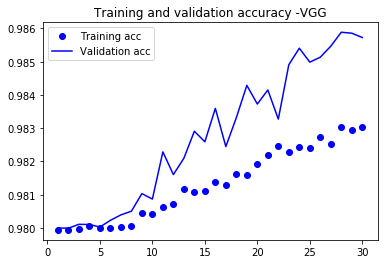

<Figure size 432x288 with 0 Axes>

In [13]:
vggacc = history_rev.history['acc']
vggval_acc = history_rev.history['val_acc']
vggloss = history_rev.history['loss']
vggval_loss = history_rev.history['val_loss']
vggepochs = range(1, len(vggacc) + 1)
plt.plot(vggepochs, vggacc, 'bo', label='Training acc')
plt.plot(vggepochs, vggval_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy -VGG')
plt.legend()
plt.figure()

Training and validation loss seems to be coming down with number of epochs and this does not indicate any overfitting of our model.

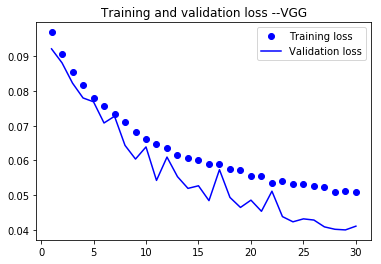

In [14]:
plt.plot(vggepochs, vggloss, 'bo', label='Training loss')
plt.plot(vggepochs, vggval_loss, 'b', label='Validation loss')
plt.title('Training and validation loss --VGG')
plt.legend()
plt.show()

Prediction accuracy seems to be quite good for us

In [15]:
print("No of Layers in Models:",len(CNNModel_Rev.layers))  # "2")
score = CNNModel_Rev.evaluate_generator(test_generator_data_rev,verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# manual test


No of Layers in Models: 23
47/47 [==============================] - 44s 946ms/step
Test loss: 0.042678416550159456
Test accuracy: 0.9850666824976603


In [16]:
Predict = CNNModel_Rev.predict_generator(test_generator_data_rev,verbose=1)


47/47 [==============================] - 38s 812ms/step


In [17]:
  print('preds_test', Predict.shape, Predict.shape, Predict)

preds_test (3000, 50) (3000, 50) [[3.73878152e-07 2.87373587e-06 7.57149130e-04 ... 7.85912052e-02
  1.26664410e-03 2.53594108e-03]
 [5.72046816e-01 3.97168934e-01 2.49273289e-04 ... 4.36795835e-06
  3.52127728e-07 2.34658273e-05]
 [1.05198051e-05 2.93345533e-06 5.88511721e-05 ... 9.82773211e-03
  1.41881988e-04 4.40939330e-04]
 ...
 [3.59498159e-07 5.38365725e-08 2.63439488e-05 ... 1.40066794e-03
  5.80257074e-06 8.75017326e-03]
 [4.92695690e-05 1.03366665e-05 6.32277952e-05 ... 1.50008636e-04
  2.94219615e-04 1.54912977e-05]
 [9.90766758e-09 6.14817452e-07 2.88321753e-04 ... 5.36838248e-02
  1.83239914e-02 5.87132876e-04]]


# Inception Network

It is always a complicated task to define and finalise filter size. Filter size can be 3*3, 5*5, 7* or 1*1. So why not use all of them and let the model decide? We do this by doing each convolution in parallel and concatenating the resulting feature maps before going to the next layer. Computation wise this is quite costly and no of parameters become quite high.

So Inception module takes all these filter as input and stack them. It is then responsibility of the network to deicide best filter and use the same. We only need to keep output size same so that we can concat each of theselayers to form inception module. 
<img src="https://hackathonprojects.files.wordpress.com/2016/09/udacity1.png">

We learn 64 1x1 filters on the input_img tensor and then we learn 64 3x3 filters on the tower_1 tensor. Similarly, we make tower_2, tower_3 tensors. We provide input_img tensor to tower_2 and tower_3 as input so all the 3x3, 5x5 filters and the max pooling layers are performed on the same input. Here padding kept same to ensure output size of CONV2D operation is same as input. We then can concat to form the inception module.

<img src="https://hackathonprojects.files.wordpress.com/2016/09/inception_implement.png">
The paper suggests first doing a 1×1 convolution  reducing the dimensionality of its feature map, passing the resulting feature map through a relu, and then doing the larger convolution (in this case, 5×5 or 3×3). The 1×1 convolution is key because it will be used to reduce the dimensionality of its feature map

In [10]:
#convolution 1st layer
droprate=0.25
droprateRev=0.55

input_img = Input(shape = (image_width,image_height, 3))

CONVtower_Input = Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
CONVtower_Input_batch = BatchNormalization()(CONVtower_Input)
#CONVtower_Input_MaxPool = MaxPooling2D()(CONVtower_Input_batch)
#CONVtower_Input_Drop = Dropout(droprate)(CONVtower_Input_MaxPool)

CONVtower_Input_2 = Conv2D(128, (3,3), padding='same', activation='relu')(CONVtower_Input_batch)
CONVtower_Input_batch_2 = BatchNormalization()(CONVtower_Input_2)
CONVtower_Input_MaxPool_2 = MaxPooling2D()(CONVtower_Input_batch_2)
CONVtower_Input_Drop_2 = Dropout(droprate)(CONVtower_Input_MaxPool_2)

CONVtower_1 = Conv2D(32, (1,1), padding='same', activation='relu')(CONVtower_Input_Drop_2)
CONVtower_1 = Conv2D(32, (3,3), padding='same', activation='relu')(CONVtower_1)

CONVtower_2 = Conv2D(32, (1,1), padding='same', activation='relu')(CONVtower_Input_Drop_2)
CONVtower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(CONVtower_2)

CONVtower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(CONVtower_Input_Drop_2)
CONVtower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(CONVtower_3)

In [11]:
CONVoutput = keras.layers.concatenate([CONVtower_1, CONVtower_2, CONVtower_3], axis = 3)

CONVtower_Input_batch_1 = BatchNormalization()(CONVoutput)
CONVtower_Input_MaxPool_1 = MaxPooling2D(3,3)(CONVtower_Input_batch_1)
CONVtower_Input_Drop_1 = Dropout(droprateRev)(CONVtower_Input_MaxPool_1)

We then have flatten the output to a one dimensional collection of neurons which is then will be used to create fully connected neural network

In [12]:
Flatoutput = Flatten()(CONVtower_Input_Drop_1)
#Denseout_1    = Dense(200, activation='relu')(Flatoutput)
#Denseout_1_Drop_1 = Dropout(droprateRev)(Flatoutput)
Denseout_2    = Dense(100, activation='relu',kernel_initializer='glorot_uniform')(Flatoutput)
Denseout_2_batch_1 = BatchNormalization()(Denseout_2)

Denseout_3    = Dense(64, activation='relu',kernel_initializer='glorot_uniform')(Denseout_2)
Denseout_4    = Dense(50, activation='softmax',kernel_initializer='uniform')(Denseout_3)

In [13]:
Incepmodel = Model(inputs = input_img, outputs = Denseout_4)

Incepmodel.compile(loss='categorical_crossentropy',
                     optimizer= 'adam',
                     metrics=['accuracy'])
Incepmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 50, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 50, 128)  73856       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [14]:
Inception_history_rev = Incepmodel.fit_generator(generator=train_generator_data_rev, 
                        steps_per_epoch=120,
                        epochs=30,                                                
                        verbose=1,
                        validation_steps=65,  
                        validation_data=validation_generator_data_rev,
                        callbacks=[reduce_lr_rev])

Epoch 1/30
120/120 [==============================] - 1492s 12s/step - loss: 3.3077 - acc: 0.1402 - val_loss: 2.8113 - val_acc: 0.2361
Epoch 2/30
120/120 [==============================] - 1338s 11s/step - loss: 2.2444 - acc: 0.3543 - val_loss: 2.0439 - val_acc: 0.4135
Epoch 3/30
120/120 [==============================] - 1308s 11s/step - loss: 1.8625 - acc: 0.4502 - val_loss: 1.9565 - val_acc: 0.4346
Epoch 4/30
120/120 [==============================] - 1345s 11s/step - loss: 1.6761 - acc: 0.5099 - val_loss: 1.9826 - val_acc: 0.4269
Epoch 5/30
120/120 [==============================] - 1372s 11s/step - loss: 1.5343 - acc: 0.5371 - val_loss: 1.5095 - val_acc: 0.5647
Epoch 6/30
120/120 [==============================] - 1303s 11s/step - loss: 1.4383 - acc: 0.5722 - val_loss: 2.2170 - val_acc: 0.3897
Epoch 7/30
120/120 [==============================] - 1547s 13s/step - loss: 1.3482 - acc: 0.5955 - val_loss: 1.5659 - val_acc: 0.5476
Epoch 8/30
120/120 [==============================] - 1

In [10]:
#reduce_lr_rev = ReduceLROnPlateau(monitor='val_loss', factor=0.002,
 #                             patience=2, min_lr=0.005)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,min_delta=0.0001,mode='auto',verbose=1,
                              patience=3, min_lr=0.000001)

Here I have tried to make one FC layer untrainable and change other layers weight to be changed depending on loss.

In [16]:
Incepmodel.trainable = True

for layers in Incepmodel.layers:
    print("Layer Name:",layers.name, end='\r')
    print(layers.name)
    if any( [layers.name == 'dense_4', layers.name == 'conv2d_8', layers.name == 'conv2d_9'] ):
        layers.trainable = False
    else:
        layers.trainable = True 
        
Incepmodel.summary()

input_1
conv2d_1
batch_normalization_1
conv2d_2
batch_normalization_2
max_pooling2d_1
dropout_1
conv2d_3
conv2d_5
max_pooling2d_2
conv2d_4
conv2d_6
conv2d_7
concatenate_1
batch_normalization_3
max_pooling2d_3
dropout_2
flatten_1
dense_1
dense_2
dense_3
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 50, 64)   256         conv2d_1[0][0]                   
______________________________________________________

In [17]:
Incepmodel.compile(loss='categorical_crossentropy',
                     optimizer= 'adam',
                     metrics=['accuracy'])
Incepmodel.summary()
print("No of Parameters after layers freezing:",len(Incepmodel.trainable_weights))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 50, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 50, 128)  73856       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [18]:
Inception_history_rev = Incepmodel.fit_generator(generator=train_generator_data_rev,
                                                 steps_per_epoch=120,
                                                 initial_epoch=30,
                                                 epochs=50,
                                                 verbose=1,
                                                 validation_steps=65,
                                                 validation_data=validation_generator_data_rev,
                                                 callbacks=[reduce_lr])        


Epoch 31/50
120/120 [==============================] - 1675s 14s/step - loss: 0.6817 - acc: 0.7849 - val_loss: 0.7234 - val_acc: 0.7815
Epoch 32/50
120/120 [==============================] - 11960s 100s/step - loss: 0.6621 - acc: 0.7936 - val_loss: 0.7264 - val_acc: 0.7837
Epoch 33/50
120/120 [==============================] - 1318s 11s/step - loss: 0.6513 - acc: 0.7961 - val_loss: 0.7005 - val_acc: 0.7851
Epoch 34/50
120/120 [==============================] - 1282s 11s/step - loss: 0.6418 - acc: 0.8027 - val_loss: 0.6643 - val_acc: 0.7940
Epoch 35/50
120/120 [==============================] - 1579s 13s/step - loss: 0.6220 - acc: 0.8062 - val_loss: 0.9131 - val_acc: 0.7365
Epoch 36/50
120/120 [==============================] - 1574s 13s/step - loss: 0.6273 - acc: 0.8023 - val_loss: 0.7151 - val_acc: 0.7844
Epoch 37/50
120/120 [==============================] - 1504s 13s/step - loss: 0.5997 - acc: 0.8188 - val_loss: 0.9823 - val_acc: 0.7113

Epoch 00037: ReduceLROnPlateau reducing learn

<Figure size 432x288 with 0 Axes>

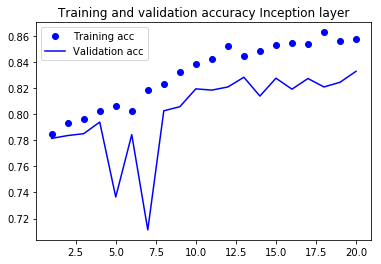

<Figure size 432x288 with 0 Axes>

In [19]:
vggacc = Inception_history_rev.history['acc']
vggval_acc = Inception_history_rev.history['val_acc']
vggloss = Inception_history_rev.history['loss']
vggval_loss = Inception_history_rev.history['val_loss']
vggepochs = range(1, len(vggacc) + 1)
plt.plot(vggepochs, vggacc, 'bo', label='Training acc')
plt.plot(vggepochs, vggval_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy Inception layer')
plt.legend()
plt.figure()

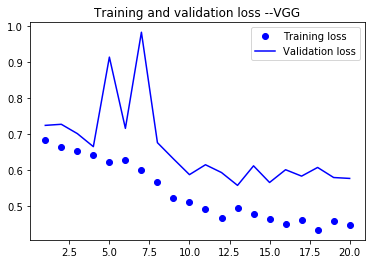

In [20]:
plt.plot(vggepochs, vggloss, 'bo', label='Training loss')
plt.plot(vggepochs, vggval_loss, 'b', label='Validation loss')
plt.title('Training and validation loss --VGG')
plt.legend()
plt.show()

In [22]:
print("No of Layers in Models:",len(Incepmodel.layers))  # "2")
score = Incepmodel.evaluate_generator(test_generator_data_rev,verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# manual test
Predict_Inception = Incepmodel.predict_generator(test_generator_data_rev,verbose=1)


No of Layers in Models: 21
47/47 [==============================] - 196s 4s/step
Test loss: 0.6935402506192525
Test accuracy: 0.8043333336512247
47/47 [==============================] - 180s 4s/step


## Residual Network

Backpropagation becomes a problem as network becomes deep and this affects network convergence. So we will sudden increase of loss during network tuning. Output of any NN layer ideally is function of inputs to the layer.
Standard approach is Y = F(X) but resnet changes this by Y=F(X) + X. So it is quite clear that it basically does the shortcircuit of two layes and this helps in gradient flows/backprogation. This helps a lot for resolving the issue of vanishing gradients and exploding gradients.
Following diagram shows residual connection architecture model.
<img src="https://image.slidesharecdn.com/mrn-161128091530/95/multimodal-residual-learning-for-visual-qa-14-638.jpg?cb=1480324582">

Residual Connection are of two types and they are
- Identity Shortcuts: This means input and output are of same size and hence they can be be connected through shortcut connection quite easily. Keeps no of parameters unchanged.
- Dimension change: Zero padding is required here to maintain output size same as input. We do the shortcut connection through 1x1 conv layer. No of parameters will be increased.

**Residual Connection with two layers** <img src="https://raw.githubusercontent.com/amitkayal/CNNDNNMystery/master/Skip-Connection-Over-2-layers.png">


**Residual Connection with three layers** <img src="https://raw.githubusercontent.com/amitkayal/CNNDNNMystery/master/Skip-Connection-Over-3-layers.png">

Upper path in the flow diagram is the shortcut path and the lower path is called main path. 

### Residual Connection with two layers

### Residual Connection with two layers

In [10]:
def conv_block(feat_maps_out, prev):
    prev = Dropout(droprate)(prev)
    prev = BatchNormalization()(prev) # Specifying the axis and mode allows for later merging
    #prev = Activation('relu')(prev)
    prev = Conv2D(feat_maps_out,(3,3), padding='same', activation='relu')(prev) 
    #prev = MaxPooling2D()(prev)
    prev = Dropout(droprate)(prev)

    
    prev = BatchNormalization()(prev) # Specifying the axis and mode allows for later merging
    #prev = Activation('relu')(prev)
    prev = Conv2D(feat_maps_out,(3,3), border_mode='same',activation='relu')(prev) 
    return prev

In [11]:
def skip_block(feat_maps_in, feat_maps_out, prev):
    if feat_maps_in != feat_maps_out:
        # This adds in a 1x1 convolution on shortcuts that map between an uneven amount of channels
        #nprev = Convolution2D(feat_maps_out, 1, 1, border_mode='same')(prev)
        nprev = Conv2D(feat_maps_out, (1,1), padding='same', activation='relu')(prev)
    return nprev 

In [12]:
def Residual(feat_maps_in, feat_maps_out, prev_layer):
    skip = skip_block(feat_maps_in, feat_maps_out, prev_layer)
    conv = conv_block(feat_maps_out, prev_layer)
    print('Residual block mapping '+str(feat_maps_in)+' channels to '+str(feat_maps_out)+' channels built')
    return keras.layers.add([skip, conv]) 

In [13]:
#reduce_lr_rev = ReduceLROnPlateau(monitor='val_loss', factor=0.002,
 #                             patience=2, min_lr=0.005)

reduce_lr_rev = ReduceLROnPlateau(monitor='val_loss', factor=0.002,
                              patience=5, min_lr=0.00001)


In [14]:
img_rows = 50  
img_cols = 50 

#convolution 1st layer
droprate=0.3
droprateRev=0.55


input_img = Input(shape = (image_width,image_height, 3))

# Define the input as a tensor with shape input_shape
input_tensor_X = Input(shape = (image_width,image_height, 3))

# Zero-Padding

input_tensor = input_tensor_X 

# Stage 1 First Component - COnvolution Layer
input_tensor_X = Conv2D(32,(3,3), activation='relu', strides=(1, 1), padding='same', input_shape=(image_height,image_width,3),name ="conv_name_base-2a")(input_tensor_X)
input_tensor_X = BatchNormalization()(input_tensor_X)
#input_tensor_X = MaxPooling2D()(input_tensor_X)
input_tensor_X = Dropout(droprate)(input_tensor_X)

###
input_tensor_X_2nd_Shortcut = input_tensor_X # Save the input value. You'll need this later to add back to the main path.

# Stage 2 - Second Component - COnvolution Layer
input_tensor_X = Conv2D(64,(3,3), padding='same',activation='relu',name ="conv_name_base-2b")(input_tensor_X)
input_tensor_X = BatchNormalization()(input_tensor_X)
input_tensor_X = MaxPooling2D()(input_tensor_X)
input_tensor_X = Dropout(droprate)(input_tensor_X)


# Stage 3 - Third Component - COnvolution Layer
input_tensor_X = Conv2D(128,(3,3), padding='valid',activation='relu',name ="conv_name_base-2c")(input_tensor_X)
input_tensor_X = BatchNormalization()(input_tensor_X)
input_tensor_X = MaxPooling2D()(input_tensor_X)
input_tensor_X = Dropout(droprateRev)(input_tensor_X)

#input_tensor_X =  Add()([X_shortcut, input_tensor_X])  # equivalent to added = keras.layers.add([x1, x2])

#Stage 4 - Fourth Component - convolution 4th layer
input_tensor_X =Conv2D(256,(3,3), padding='valid',activation='relu',name ="conv_name_base-2d")(input_tensor_X)
input_tensor_X = BatchNormalization()(input_tensor_X)
input_tensor_X = MaxPooling2D()(input_tensor_X)
input_tensor_X = Dropout(droprateRev)(input_tensor_X)

print("P2-Shortcut Path Tensor Shape before conv:",input_tensor_X_2nd_Shortcut.shape)
print("P2-Main Path Tensor Shape - before zero padding:",input_tensor_X.shape)

### So here we see that there is shape difference and we need to bring the shortcut path to same shape of main path
input_tensor_X = ZeroPadding2D(2)(input_tensor_X)

input_tensor_X_2nd_Shortcut = Conv2D(256,(1,1), strides=(7, 7), padding='valid',activation='relu',name ="conv_name_shortcut-2f")(input_tensor_X_2nd_Shortcut)


print("P2-Shortcut Path Tensor Shape-before Merge:",input_tensor_X_2nd_Shortcut.shape)
print("P2-Main Path Tensor Shape - before Merge:",input_tensor_X.shape)

input_tensor_X =  Add()([input_tensor_X_2nd_Shortcut, input_tensor_X])  # equivalent to added = keras.layers.add([x1, x2])

input_tensor_X = Activation('relu')(input_tensor_X)
input_tensor_X = MaxPooling2D()(input_tensor_X)
input_tensor_X = Dropout(droprateRev)(input_tensor_X)

# output layer
print("Main Path Tensor Shape before flatening:",input_tensor_X.shape)

input_tensor_X = Flatten()(input_tensor_X)
input_tensor_X = Dense(256, activation='relu',name ="First_FC_Layer")(input_tensor_X)

input_tensor_X =Dense(128, activation='relu',use_bias=False, kernel_initializer='glorot_uniform',name ="Second_FC_Layer")(input_tensor_X)

Output_Tensor = Dense(50, activation='softmax')(input_tensor_X)

# Create model
modelRes = Model(inputs=input_tensor,outputs=Output_Tensor)


P2-Shortcut Path Tensor Shape before conv: (?, 50, 50, 32)
P2-Main Path Tensor Shape - before zero padding: (?, 4, 4, 256)
P2-Shortcut Path Tensor Shape-before Merge: (?, 8, 8, 256)
P2-Main Path Tensor Shape - before Merge: (?, 8, 8, 256)
Main Path Tensor Shape before flatening: (?, 4, 4, 256)


In [15]:
modelRes.compile(loss='categorical_crossentropy',
                     optimizer= 'adam',
                     metrics=['accuracy'])
modelRes.summary()
print("No of Parameters after layers freezing:",len(modelRes.trainable_weights))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv_name_base-2a (Conv2D)      (None, 50, 50, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 50, 32)   128         conv_name_base-2a[0][0]          
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 50, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv_name_

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.11,min_delta=0.0011,mode='auto',verbose=1,
                              patience=1, min_lr=0.000005)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.11,min_delta=0.0001,mode='auto',verbose=1,
                              patience=1, min_lr=0.0000025)

In [17]:
Model_Res_history_rev = modelRes.fit_generator(generator=train_generator_data_rev, 
                        steps_per_epoch=120,
                        epochs=30,                                                
                        verbose=1,
                        validation_steps=65,  
                        validation_data=validation_generator_data_rev,
                        callbacks=[reduce_lr])

Epoch 1/30
120/120 [==============================] - 986s 8s/step - loss: 4.0024 - acc: 0.0393 - val_loss: 3.8873 - val_acc: 0.0425
Epoch 2/30
120/120 [==============================] - 1009s 8s/step - loss: 3.7442 - acc: 0.0609 - val_loss: 3.7723 - val_acc: 0.0488
Epoch 3/30
120/120 [==============================] - 972s 8s/step - loss: 3.4662 - acc: 0.0965 - val_loss: 3.3674 - val_acc: 0.1305
Epoch 4/30
120/120 [==============================] - 982s 8s/step - loss: 3.2213 - acc: 0.1299 - val_loss: 3.2627 - val_acc: 0.1190
Epoch 5/30
120/120 [==============================] - 913s 8s/step - loss: 3.0190 - acc: 0.1648 - val_loss: 3.0400 - val_acc: 0.1762
Epoch 6/30
120/120 [==============================] - 888s 7s/step - loss: 2.8871 - acc: 0.1932 - val_loss: 2.9807 - val_acc: 0.1882
Epoch 7/30
120/120 [==============================] - 882s 7s/step - loss: 2.7553 - acc: 0.2301 - val_loss: 2.6825 - val_acc: 0.2418
Epoch 8/30
120/120 [==============================] - 876s 7s/step -

<Figure size 432x288 with 0 Axes>

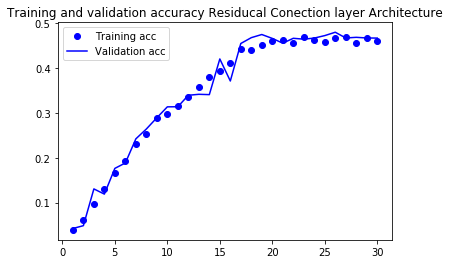

<Figure size 432x288 with 0 Axes>

In [18]:
vggacc = Model_Res_history_rev.history['acc']
vggval_acc = Model_Res_history_rev.history['val_acc']
vggloss = Model_Res_history_rev.history['loss']
vggval_loss = Model_Res_history_rev.history['val_loss']
vggepochs = range(1, len(vggacc) + 1)
plt.plot(vggepochs, vggacc, 'bo', label='Training acc')
plt.plot(vggepochs, vggval_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy Residucal Conection layer Architecture')
plt.legend()
plt.figure()

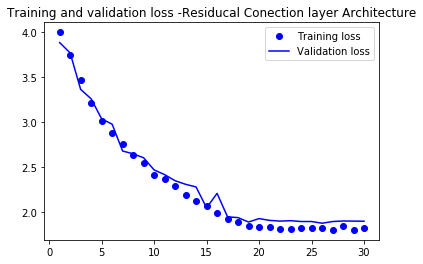

In [19]:
plt.plot(vggepochs, vggloss, 'bo', label='Training loss')
plt.plot(vggepochs, vggval_loss, 'b', label='Validation loss')
plt.title('Training and validation loss -Residucal Conection layer Architecture')
plt.legend()
plt.show()

In [24]:
modelRes.trainable = True

for layers in modelRes.layers:
    print("Res Layer Name:",layers.name, end='\r')
    print(layers.name)
    if any( [layers.name == 'xx', layers.name == 'Second_FC_Layer'] ):
        layers.trainable = False
    else:
        layers.trainable = True 
        
modelRes.summary()

input_2
conv_name_base-2a
batch_normalization_1
dropout_1
conv_name_base-2b
batch_normalization_2
max_pooling2d_1
dropout_2
conv_name_base-2c
batch_normalization_3
max_pooling2d_2
dropout_3
conv_name_base-2d
batch_normalization_4
max_pooling2d_3
dropout_4
conv_name_shortcut-2f
zero_padding2d_1
add_1
activation_1
max_pooling2d_4
dropout_5
flatten_1
First_FC_Layer
Second_FC_Layer
dense_1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv_name_base-2a (Conv2D)      (None, 50, 50, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalizati

c:\users\akayal\devapps\python36-64\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [26]:
modelRes.compile(loss='categorical_crossentropy',
                     optimizer= 'sgd',
                     metrics=['accuracy'])
modelRes.summary()
print("No of Parameters after layers freezing:",len(modelRes.trainable_weights))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv_name_base-2a (Conv2D)      (None, 50, 50, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 50, 32)   128         conv_name_base-2a[0][0]          
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 50, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv_name_

In [28]:
reduce_lr_r = ReduceLROnPlateau(monitor='val_loss', factor=0.105,min_delta=0.0001,mode='auto',verbose=1,
                              patience=1, min_lr=0.0000025)

In [29]:
Model_Res_history_rev = modelRes.fit_generator(generator=train_generator_data_rev,
                                                 steps_per_epoch=120,
                                                 initial_epoch=30,
                                                 epochs=70,
                                                 verbose=1,
                                                 validation_steps=65,
                                                 validation_data=validation_generator_data_rev,
                                                 callbacks=[reduce_lr_r])        


Epoch 31/70
120/120 [==============================] - 911s 8s/step - loss: 1.8573 - acc: 0.4542 - val_loss: 1.8702 - val_acc: 0.4685
Epoch 32/70
120/120 [==============================] - 939s 8s/step - loss: 1.8459 - acc: 0.4493 - val_loss: 2.0012 - val_acc: 0.4322

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.001049999976530671.
Epoch 33/70
120/120 [==============================] - 947s 8s/step - loss: 1.8193 - acc: 0.4682 - val_loss: 1.9038 - val_acc: 0.4671

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.00011024999606888741.
Epoch 34/70
120/120 [==============================] - 916s 8s/step - loss: 1.8072 - acc: 0.4666 - val_loss: 1.8983 - val_acc: 0.4678

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.1576249526115133e-05.
Epoch 35/70
120/120 [==============================] - 931s 8s/step - loss: 1.8264 - acc: 0.4653 - val_loss: 1.8809 - val_acc: 0.4772

Epoch 00035: ReduceLROnPlateau reducing learning rate to 2.5e-06.
Epoch 36/70
120/120

<Figure size 432x288 with 0 Axes>

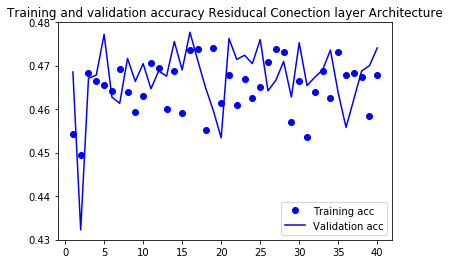

<Figure size 432x288 with 0 Axes>

In [31]:
vggacc = Model_Res_history_rev.history['acc']
vggval_acc = Model_Res_history_rev.history['val_acc']
vggloss = Model_Res_history_rev.history['loss']
vggval_loss = Model_Res_history_rev.history['val_loss']
vggepochs = range(1, len(vggacc) + 1)
plt.plot(vggepochs, vggacc, 'bo', label='Training acc')
plt.plot(vggepochs, vggval_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy Residucal Conection layer Architecture')
plt.legend()
plt.figure()

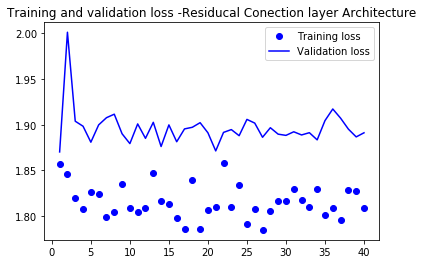

In [32]:
plt.plot(vggepochs, vggloss, 'bo', label='Training loss')
plt.plot(vggepochs, vggval_loss, 'b', label='Validation loss')
plt.title('Training and validation loss -Residucal Conection layer Architecture')
plt.legend()
plt.show()